# 1) import library & packages

In [1]:
from comet_ml import Experiment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import random
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
import string
from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import svm
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

[nltk_data] Downloading package stopwords to /home/fberes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/fberes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


%%bash
git clone https://github.com/bartalisd/apricot_exp.git

%%bash
cd apricot_exp
pip install .

In [2]:
#default theme
sns.set(context='notebook', style='darkgrid', palette='colorblind', font='sans-serif', font_scale=1, rc=None)
matplotlib.rcParams['figure.figsize'] =[8,8]
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['font.family'] = 'sans-serif'

# 2) load data & analysis

In [3]:
with open("../data_root.txt") as f:
    data_root_dir = f.read()
data_root_dir

'/mnt/idms/home/bartalisd/elteprojekt/data'

In [4]:
train = pd.read_csv('%s/tweet_disaster/train.csv' % data_root_dir)
test = pd.read_csv('%s/tweet_disaster/test.csv' % data_root_dir)
#sub = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [5]:
print(train.shape,test.shape)

(7613, 5) (3263, 4)


In [6]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


### finding missing values

In [9]:
missing_values=train.isnull().sum()
percent_missing = train.isnull().sum()/train.shape[0]*100

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing
}
frame=pd.DataFrame(value)
frame

,missing_values,percent_missing %
id,0,0.000000
keyword,61,0.801261
location,2533,33.272035
text,0,0.000000
target,0,0.000000


In [10]:
#Remove redundant samples
train=train.drop_duplicates(subset=['text', 'target'], keep='first')
train.shape

(7521, 5)

We have 92 redundants sapmles in our dataset

In [11]:
train.target.value_counts()

0    4315
1    3206
Name: target, dtype: int64

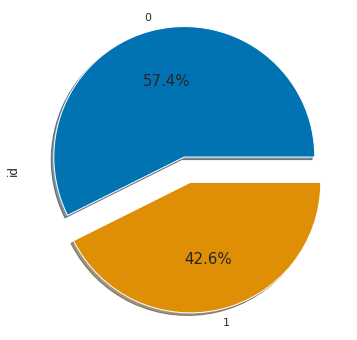

In [12]:
fig = plt.figure(figsize=(8,6))
train.groupby('target').id.count().plot.pie(explode=[0.1,0.1],autopct='%1.1f%%',shadow=True)
plt.show()

labels are not balanced

In [13]:
# Numbers of word for each sapmle in train & test data
train['text_length'] = train.text.apply(lambda x: len(x.split()))
test['text_length'] = test.text.apply(lambda x: len(x.split()))


Max number of words in all data is 31 and min is 1!

In [14]:
# collecting all words in single list
list_= []
for i in train.text:
    list_ += i
list_= ''.join(list_)
allWords=list_.split()
vocabulary= set(allWords)

In [15]:
len(vocabulary)

31480

We have 31480 different words in our train data

# 3) Data Cleaning

In [16]:
#list of stopwords
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [17]:
pstem = PorterStemmer()
def clean_text(text):
    text= text.lower()
    text= re.sub('[0-9]', '', text)
    text  = "".join([char for char in text if char not in string.punctuation])
    tokens = word_tokenize(text)
    tokens=[pstem.stem(word) for word in tokens]
    # This line below must be enabled to remove stop words (is it because original model needed the stop words too?)
    tokens=[word for word in tokens if word not in stopwords.words('english')]
    text = ' '.join(tokens)
    return text

In [18]:
clean_text("hey I am here # ! looks 4 GOOD can't see you!")

'hey look good cant see'

In [19]:
train["clean"]=train["text"].apply(clean_text)
test["clean"]=test["text"].apply(clean_text)

In [20]:
#Let's see the effect of cleaning
train[["text","clean"]].head()

,text,clean
0,Our Deeds are the Reason of this #earthquake M...,deed reason thi earthquak may allah forgiv us
1,Forest fire near La Ronge Sask. Canada,forest fire near la rong sask canada
2,All residents asked to 'shelter in place' are ...,resid ask shelter place notifi offic evacu she...
3,"13,000 people receive #wildfires evacuation or...",peopl receiv wildfir evacu order california
4,Just got sent this photo from Ruby #Alaska as ...,got sent thi photo rubi alaska smoke wildfir p...


In [21]:
# collecting all words in single list
list_= []
for i in train.clean:
    list_ += i
list_= ''.join(list_)
allWords=list_.split()
vocabulary= set(allWords)
len(vocabulary)

19920

we reduced our data from 31480 unique words to 19920

In [22]:
X=train['clean']
Y=train['target']
from apricot_exp.evaluation import traintest
X_train, X_test, Y_train, Y_test = traintest(X,Y,0.3)

In [23]:
Y_train

3641    1
6138    0
4584    0
6139    0
296     0
       ..
5258    1
5294    1
5458    1
866     0
7355    1
Name: target, Length: 5264, dtype: int64

In [24]:
max_num_features = 10000

In [25]:
tfidf = TfidfVectorizer(sublinear_tf=True,max_features=max_num_features, min_df=1, norm='l2',  ngram_range=(1,2))
features = tfidf.fit_transform(X_train).toarray()
features_test = tfidf.transform(X_test).toarray()
print(features.shape, features_test.shape)

(5264, 10000) (2257, 10000)


In [26]:
features_p=pd.DataFrame(features)
print(features_p.shape)
features_t=features_p.transpose()
print(features_t.shape)

(5264, 10000)
(10000, 5264)


In [27]:
features_test_p=pd.DataFrame(features_test)
print(features_test_p.shape)
features_test_t=features_test_p.transpose()
print(features_test_t.shape)

(2257, 10000)
(10000, 2257)


In [28]:
model = LogisticRegression(max_iter=1000)

In [29]:
from apricot_exp.comet_utils import *
api_key = load_api_key('../../comet_key.txt')

In [31]:
n = 9000
experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
experiment.log_parameters({
    'size': None,
    'function': None
})
tfidf = TfidfVectorizer(sublinear_tf=True,max_features=n, min_df=1, norm='l2',  ngram_range=(1,2))
features = tfidf.fit_transform(X_train).toarray()
features_test = tfidf.transform(X_test).toarray()
print(features.shape, features_test.shape)
from apricot_exp.evaluation import train_eval
train_eval(model, features,  Y_train, features_test, Y_test, experiment)
experiment.end()

COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/8c6000135184484c9d5c5bdb16150a2a



(5264, 9000) (2257, 9000)


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


In [ ]:
from apricot_exp.func_tp import featureb, facilityloc, maxcov

In [ ]:
for i in [100, 500, 1000, 2500, 5000, 7500, 8000, 9000]:
    experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
    experiment.log_parameters({
        'size': i,
        'function': 'featurebased'
    })
    n = i
    #start_time = time.time()
    Xtr_t, Xte_t = featureb(features_t, features_test_t, n, 'sqrt')
    #experiment.log_metric("running_time", time.time()-start_time)
    Xtr = Xtr_t.transpose()
    Xte = Xte_t.transpose()
    from apricot_exp.evaluation import train_eval
    train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
    experiment.end()

COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/499976afd40c422d87765d012a31f8c5

COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: Config key 'comet.auto_log.weights' is deprecated, please use 'comet.auto_log.histogram_weights' instead
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/apricot/tweet-disaster/8e9f717150f94ffc97ed4ec5bb997c0d

COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: Config key 'comet.auto_log.weights' i

In [ ]:
for i in [100, 500, 1000, 2500, 5000, 7500, 8000, 9000]: 
    experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
    experiment.log_parameters({
        'size': i,
        'function': 'facilitylocation'
    })
    n = i
    Xtr_t, Xte_t = facilityloc(features_t, features_test_t, n, 'euclidean')
    Xtr = Xtr_t.transpose()
    Xte = Xte_t.transpose()
    from apricot_exp.evaluation import train_eval
    train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
    experiment.end()

In [ ]:
for i in [100, 500, 1000, 2500, 5000, 7500, 8000, 9000]: 
    n = i
    experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
    experiment.log_parameters({
        'size': i,
        'function': 'maxcoverage'
    })
    from apricot_exp.func_tp import maxcov
    Xtr_t, Xte_t = maxcov(features_t, features_test_t, n)
    Xtr = Xtr_t.transpose()
    Xte = Xte_t.transpose()
    from apricot_exp.evaluation import train_eval
    train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
    experiment.end()

In [ ]:
def randomtrain(X_tr, X_te, n):
    X_train_arr = X_tr.to_numpy()
    X_test_arr = X_te.to_numpy() 
    print(X_train_arr.shape, X_test_arr.shape)
    idxs = np.arange(X_tr.shape[0])
    np.random.shuffle(idxs)
    idx = idxs[:n]
    Xtr, Xte = X_train_arr[idx,:], X_test_arr[idx,:]
    return Xtr, Xte

In [ ]:
for j in [100, 500, 1000, 2500, 5000, 7500, 8000, 9000]: 
    for i in range(1,20):
        n = j
        experiment=init_experiment(api_key, 'tweet_disaster', 'apricot')
        experiment.log_parameters({
            'size': i,
            'function': 'random'
        })
        Xtr_t, Xte_t = randomtrain(features_t, features_test_t, n)
        Xtr = Xtr_t.transpose()
        Xte = Xte_t.transpose()
        from apricot_exp.evaluation import train_eval
        train_eval(model, Xtr, Y_train, Xte, Y_test, experiment)
        i = i+1
        experiment.end()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=20, max_depth=3)

In [ ]:
from apricot_exp.evaluation import train_eval
train_eval(model, features,  Y_train, features_test, Y_test, experiment)

## PCA

In [ ]:
pca = PCA(n_components=2)

In [ ]:
from sklearn.preprocessing import StandardScaler
f = list(range(0, 10000))
x = features[:, f]
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

## Visualization

In [ ]:
import neptune
project = neptune.init(project_qualified_name='bartalisd/nlp-disaster-tweets',
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNmY5YjdlNTgtNjMxNC00ODQyLThiNGItNmM5NTBmZTM1MjA4In0=', 
            )

# Download experiments dashboard as pandas DataFrame
data = project.get_leaderboard()

data=data[data['tags'].map(len) > 1]
data = data.drop(['name','created', 'finished','owner','notes', 'running_time','size'], axis=1)
for i in ['channel_roc', 'channel_acc', 'channel_rec', 'channel_pre']:
    data[i]=data[i].astype("float64")

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
def barplot_res(dataframe, percentage, metric, y_name):
    selector = dataframe.apply(lambda x: percentage in x["tags"], axis=1)
    data_percentage=dataframe.loc[selector, :]
    data_percentage["tags"]=data_percentage["tags"].apply(lambda x: str(x))
    res_percentage=data_percentage.groupby(by='tags')[metric].mean().reset_index()
    res_percentage['model']=res_percentage['tags'].apply(lambda x: eval(x)[1])
    ax=sns.barplot(data=res_percentage, x='model', y=metric)
    plt.ylim((0.5, 0.9))
    ax.set(xlabel='Model', ylabel=y_name, title =percentage)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
    return ax, res_percentage
def lineplot_res(dataframe, y_name, metric, res5k, mod):
    data=dataframe.copy()
    data['percentage']=data['tags'].apply(lambda x: x[1])
    data=data[~data['percentage'].apply(lambda x: 'd' in str(x))]
    data['model']=data['tags'].apply(lambda x: x[0])
    functions=['facilityloc_d', 'featurebased_d', 'maxcov_d', 'random_d', 'Tfidf']
    data=data[data['model'].isin(functions)]
    result=data.groupby(by=['model','percentage'])[metric].mean().reset_index()
    ax=sns.lineplot(data=result, x='percentage', y=metric, hue='model', palette=['yellow', 'b','r','forestgreen','blueviolet'  ])
    ax.set_title(mod,fontdict= { 'fontsize': 20, 'fontweight':'bold'})
    plt.xlabel('Number of features', fontsize= 15)
    plt.ylabel(y_name, fontsize= 15)
    plt.axhline(y=res5k, color='brown', linestyle='--')
    plt.setp(ax.get_legend().get_texts(), fontsize='15')
    plt.setp(ax.get_legend().get_title(), fontsize='20')
    return ax

In [ ]:
lineplot_res(data, 'Accuracy', 'channel_acc', 0.7984049623393886, 'NLP - Disasters tweets: Dim reduction' )

In [ ]:
lineplot_res(data, 'Precision', 'channel_pre', 0.8259162303664922, 'NLP - Disasters tweets: Dim reduction' )

In [ ]:
lineplot_res(data, 'Recall', 'channel_rec', 0.6621196222455404, 'NLP - Disasters tweets: Dim reduction' )

In [ ]:
lineplot_res(data, 'ROC AUC', 'channel_roc', 0.8622086211447222, 'NLP - Disasters tweets: Dim reduction' )